In [5]:
import torchvision
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os 
import matplotlib.pyplot as plt
import time 
from torch import linalg as LA
from copy import deepcopy 

In [6]:
current_dir = os.path.dirname(os.path.abspath(''))
data_dir = os.path.join(current_dir, 'final', 'data')
print(data_dir)
if not os.path.exists(data_dir): 
    os.makedirs(data_dir)

/home/hgiang/2022_coding/neural-network-1/final/data


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)

mnist_image = []
mnist_target = []
for image, target in mnist_train: 
    mnist_image.append(np.asarray(image).reshape(-1))
    mnist_target.append(target)

mnist_image = np.asarray(mnist_image)
mnist_target = np.asarray(mnist_target)

# Normalize the image data
mu = np.mean(mnist_image, axis=0).reshape(28, 28)
sigma = np.std(mnist_image, axis=0).reshape(28, 28)

print(f"mu = {mu.shape}, sigma = {sigma.shape}")

mu = (28, 28), sigma = (28, 28)


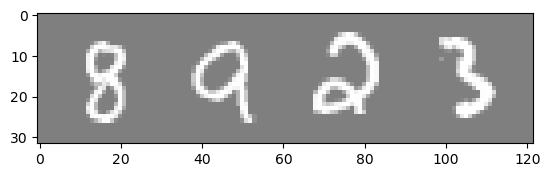

    8     9     2     3
max(mnist_image[0]) = 1.0, min(mnist_image[0]) = 0.0


In [9]:
batch_size=4

# transform = transforms.ToTensor()
tranform = transforms.Normalize(mu, sigma, inplace=False)

# Get MNIST data, normalize, divide by level 
mnist_train = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
testset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))
print(f"max(mnist_image[0]) = {torch.max(images[0][0])}, min(mnist_image[0]) = {torch.min(images[0][0])}")

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        x = self.linear(x)
        return x

In [32]:
def compute_jab(loss, net_params):
    J = torch.autograd.grad(loss, list(net_params), create_graph=True)
    J = torch.cat([e.flatten() for e in J]) # flatten
    return J

In [26]:
def compute_hess(jab, net_params): 
    num_param = sum(p.numel() for p in net_params)
    # Allocate Hessian size
    H = torch.zeros((num_param, num_param))
    
    for i in range(num_param):
        result = torch.autograd.grad(jab[i], list(net.parameters()), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result]) # flatten
    
    return H 

In [13]:
def norm_params(param1, param2): 
    
    # Flatten parameters 
    p1 = torch.cat([e.flatten() for e in param1])
    p2 = torch.cat([e.flatten() for e in param2])

    p = p1 - p2 
    return LA.vector_norm(p, ord=1).item()

In [14]:
def calc_norm(param): 
    p = torch.cat([e.flatten() for e in param])
    return LA.vector_norm(p, ord=1).item()

In [15]:
def compute_loss(net, criterion, dataloader): 
    loss = torch.zeros(1, device=device)
    num_batches = len(dataloader)
    for batch, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        inputs = inputs.view(-1, 784)
        loss += criterion(net(inputs), labels)
    
    loss = loss/num_batches
    return loss 

In [53]:
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [54]:
size = len(trainloader.dataset)
num_batches = len(trainloader)

num_epochs = 5 

loss1 = compute_loss(net, criterion, trainloader)
# Get initial parameters 
p1 = net.parameters()
jab1 = compute_jab(loss1, net.parameters())
print(f"p1 = {calc_norm(p1)}, loss1 = {calc_norm(loss1)}, jab1 = {calc_norm(jab1)}")
 
for epoch in range(num_epochs):
    accumulated_loss = torch.zeros(1, device=device)
    
    # Train to update the model parameters 
    for batch, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        inputs = inputs.view(-1, 784)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        pred = net(inputs)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        accumulated_loss += loss
    
    
    # Finish training, get parameters 
    p2 = net.parameters() 
    loss2 = accumulated_loss

    jab2 = compute_jab(loss2, net.parameters())
    # print(f"p2 = {calc_norm(p2)}, loss2 = {calc_norm(loss2)}, jab2 = {calc_norm(jab2)}")

    param_norm = norm_params(p1, p2)
    loss_norm = norm_params(loss1, loss2)
    jab_norm = norm_params(jab1, jab2)
    
    rho = loss_norm/param_norm
    beta = jab_norm/param_norm
    print(f"rho = {rho} beta = {beta}")

    loss1 = deepcopy(loss2)
    p1 = deepcopy(p2)
    jab1 = deepcopy(jab2)

p1 = 139.29965209960938, loss1 = 2.3213980197906494, jab1 = 52.422149658203125


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [13]:
current_dir = os.path.dirname(os.path.abspath(''))
model_path = os.path.join(current_dir, 'final', 'mnist_net.pth')
torch.save(net.state_dict(), model_path)

In [8]:
testloader = DataLoader(testset, batch_size=10000, shuffle=False, pin_memory=True)

num_param = sum(p.numel() for p in net.parameters())
''' Calculate Hessian '''

min_hess = []
max_hess = []

start = time.time()

for _ in range(10): 
    for batch, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        inputs = inputs.view(-1, 784)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred = net(inputs)
        loss = criterion(pred, labels)

        # Allocate Hessian size
        H = torch.zeros((num_param, num_param))

        # Calculate Jacobian w.r.t. model parameters
        J = torch.autograd.grad(loss, list(net.parameters()), create_graph=True)
        J = torch.cat([e.flatten() for e in J]) # flatten

        # Fill in Hessian
        for i in range(num_param):
            result = torch.autograd.grad(J[i], list(net.parameters()), retain_graph=True)
            H[i] = torch.cat([r.flatten() for r in result]) # flatten
        
        print(torch.min(H), torch.max(H))
        min_hess.append(torch.min(H))
        max_hess.append(torch.max(H))

        break 

min_hess = torch.tensor(min_hess)
max_hess = torch.tensor(max_hess)

print(f"min_hess = {min_hess} max_hess = {max_hess}")

tensor(-0.0423) tensor(0.0633)
tensor(-0.0272) tensor(0.0547)
tensor(-0.0232) tensor(0.0731)
tensor(-0.0428) tensor(0.1004)
tensor(-0.0449) tensor(0.0500)
tensor(-0.0400) tensor(0.0871)
tensor(-0.0308) tensor(0.0491)
tensor(-0.0318) tensor(0.0427)
tensor(-0.0471) tensor(0.1076)
tensor(-0.0751) tensor(0.2187)
min_hess = tensor([-0.0423, -0.0272, -0.0232, -0.0428, -0.0449, -0.0400, -0.0308, -0.0318,
        -0.0471, -0.0751]) max_hess = tensor([0.0633, 0.0547, 0.0731, 0.1004, 0.0500, 0.0871, 0.0491, 0.0427, 0.1076,
        0.2187])


In [9]:
torch.mean(min_hess)

tensor(-0.0405)

In [10]:
torch.mean(max_hess)

tensor(0.0847)

In [11]:
Ff = 0.061; F0 = 1.643; Fn = 0.322

In [12]:
(Fn - Ff)/(F0 - Ff)

0.1649810366624526

In [15]:
torch.zeros(1)

tensor([0.])

In [16]:
x = torch.randn(3)

In [27]:
x.shape
# x

torch.Size([3])

In [19]:
y = torch.rand((3, 3))

In [20]:
y

tensor([[0.6816, 0.3936, 0.8691],
        [0.7012, 0.7457, 0.9011],
        [0.2661, 0.2115, 0.2770]])

In [25]:
y = y.view(-1)

In [26]:
y.shape

torch.Size([9])

In [30]:
hess = torch.load('hessian.pt')

In [31]:
torch.max(hess)

tensor(11.8505, device='cuda:0', grad_fn=<MaxBackward1>)

In [32]:
torch.min(hess)

tensor(-8.7001, device='cuda:0', grad_fn=<MinBackward1>)

In [33]:
jab = torch.load('jacobian.pt')

In [40]:
jab = torch.tensor(jab)

ValueError: only one element tensors can be converted to Python scalars

In [36]:
torch.max(jab[0][1])

tensor(1.0359, device='cuda:0', grad_fn=<MaxBackward1>)

In [37]:
torch.min(jab[0][1])

tensor(-1.5386, device='cuda:0', grad_fn=<MinBackward1>)

In [38]:
torch.min(jab[0][0])

tensor(-0.6835, device='cuda:0', grad_fn=<MinBackward1>)